<a href="https://colab.research.google.com/github/rodolfolermacontreras/Fine-Tuning-For-Sentiment-Analysis/blob/main/Final_Finetuning_BERT_Classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets

import pandas as pd
import numpy as np
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset
from sklearn.metrics import classification_report, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the dataset from Google Drive
file_path = '/content/drive/My Drive/Marinus/Fine_Tune_Data.csv'
df = pd.read_csv(file_path)

df = df.rename(columns={'Clean_Text': 'text', 'Label': 'label'})
df = df[['text', 'label']]
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype(int)

In [4]:
# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        return {
            'input_ids': inputs['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(0),  # Remove batch dimension
            'labels': torch.tensor(label)
        }

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# Split the data into train, validation, and test sets
train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

# Create datasets
train_dataset = CustomDataset(train_df['text'].tolist(), train_df['label'].tolist(), tokenizer)
val_dataset = CustomDataset(val_df['text'].tolist(), val_df['label'].tolist(), tokenizer)
test_dataset = CustomDataset(test_df['text'].tolist(), test_df['label'].tolist(), tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [11]:
# Training loop
num_epochs = 50
num_warmup_steps = 0
num_training_steps = num_epochs * len(train_loader)

# Apply weight decay for regularization
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# Apply learning rate scheduling
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

best_val_loss = float('inf')
best_model = None
patience = 5
epochs_without_improvement = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        batch = {k: v.to(device) for k, v in batch.items()}

        # Apply gradient accumulation
        outputs = model(**batch)
        loss = outputs.loss / 4  # Accumulate gradients over 4 batches
        loss.backward()

        train_loss += loss.item()

        # Update weights and apply learning rate scheduling
        if (batch_idx + 1) % 4 == 0 or batch_idx == len(train_loader) - 1:  # Update weights after every 4 batches or at the end of the epoch
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    train_losses.append(train_loss / len(train_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_loss / len(train_loader)}")

    # Evaluate on the validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1} | Val Loss: {val_loss}")

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. Best validation loss: {best_val_loss}")
            break

# Load the best model
model.load_state_dict(best_model)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.03515492784444595
Epoch 1 | Val Loss: 0.7374855130910873


Training Epoch 2:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.026899682758124294
Epoch 2 | Val Loss: 0.8408832401037216


Training Epoch 3:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.020364274925275427
Epoch 3 | Val Loss: 0.9109707673390707


Training Epoch 4:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.020730946636507035
Epoch 4 | Val Loss: 0.8508157332738241


Training Epoch 5:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.01051339026783574
Epoch 5 | Val Loss: 1.2873956461747487


Training Epoch 6:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.008952821870263653
Epoch 6 | Val Loss: 1.2049960692723591
Early stopping triggered. Best validation loss: 0.7374855130910873


<All keys matched successfully>

In [12]:
# Evaluate the best model on the test set
model.eval()
test_loss = 0
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        test_loss += outputs.loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")
print("Classification Report:")
print(classification_report(true_labels, predictions))

Test Loss: 0.9642737532655398
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       147
           1       0.59      0.61      0.60        38

    accuracy                           0.83       185
   macro avg       0.74      0.75      0.75       185
weighted avg       0.83      0.83      0.83       185



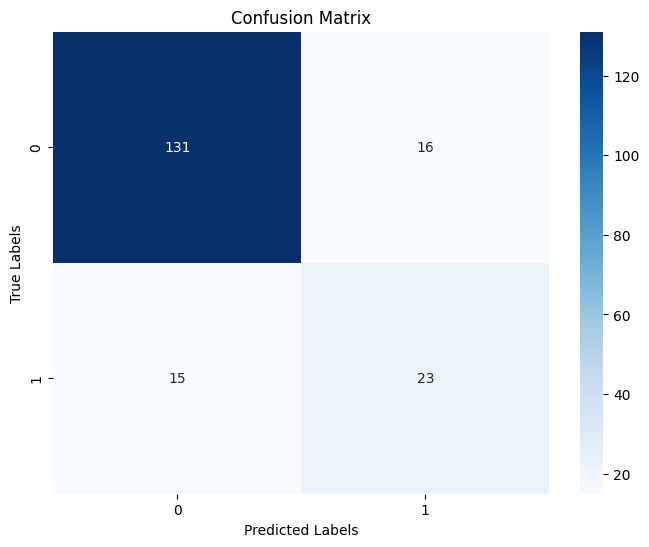

In [13]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Save the trained model
model_save_path = '/content/drive/My Drive/Marinus/distilbert_model.pth'
torch.save(model.state_dict(), model_save_path)

# Load the saved model
loaded_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.to(device)
loaded_model.eval()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [15]:
# Make predictions on the test data
predictions = []
true_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = loaded_model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

# Classification report
print("Performance on Test Data:")
print(classification_report(true_labels, predictions))

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Performance on Test Data:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       147
           1       0.59      0.61      0.60        38

    accuracy                           0.83       185
   macro avg       0.74      0.75      0.75       185
weighted avg       0.83      0.83      0.83       185



### Test on Ground Truth Cases

In [19]:
# Load the new dataset
new_data_path = '/content/drive/My Drive/Marinus/Example.csv'
new_df = pd.read_csv(new_data_path)

# Assuming the text column in the new dataset is named 'text'
new_df = new_df.rename(columns={'Clean_Text': 'text'})
new_df = new_df[['text']]
new_df['text'] = new_df['text'].astype(str)
texts = new_df['text'].tolist()

In [18]:
# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create a dataset for the new data
class NewDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0)
        }

new_dataset = NewDataset(texts, tokenizer)

# Create a data loader for the new dataset
new_data_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)

# Load the saved model
model_path = '/content/drive/My Drive/Marinus/distilbert_model.pth'
loaded_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

# Make predictions on the new data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model.to(device)

predictions = []
with torch.no_grad():
    for batch in tqdm(new_data_loader, desc="Predicting"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = loaded_model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.cpu().numpy())

# Add the predictions to the new dataset
new_df['predicted_label'] = predictions

# Save the updated dataset with predictions
new_df.to_csv('/content/drive/My Drive/Marinus/predictions.csv', index=False)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicting:   0%|          | 0/1 [00:00<?, ?it/s]